In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model
import astropy.units as u

def run_pahfit_for_galaxy(galaxy_folder: Path, n_rings: int = 8, redshift: float = 0.016268):
    """
    Runs PAHFIT and PAHdb processing for a given galaxy folder.
    Assumes FITS files are named {galaxy_name}_Ring{i}_1dspec.fits in the folder.
    """
    galaxy_folder = Path(galaxy_folder)
    galaxy_name = galaxy_folder.name
    hydrocarbon_dir = galaxy_folder
    polycyclic_dir = galaxy_folder / "PAHFIT_results"
    polycyclic_dir.mkdir(exist_ok=True)

    # 1. PAHFIT fitting, save results, and show PAHFIT plots
    for i in range(1, n_rings + 1):
        fits_file = hydrocarbon_dir / f"{galaxy_name}_Ring{i}_1dspec_manual.fits"
        output_file = polycyclic_dir / f"{galaxy_name}_Ring{i}_pahfit.ecsv"
        if not fits_file.exists():
            print(f"[SKIP] Not found: {fits_file}")
            continue

        table = Table.read(fits_file, hdu=1)
        wavelengths = u.Quantity(table['wavelength'].data, unit=u.um)
        fluxes = u.Quantity(table['flux'].data, unit=u.MJy / u.sr)
        errors = StdDevUncertainty(0.05 * fluxes)

        spec = Spectrum1D(spectral_axis=wavelengths, flux=fluxes, uncertainty=errors)
        spec.meta['instrument'] = 'jwst.miri.*.*'
        spec.set_redshift_to(redshift)

        model = Model.from_yaml('classic.yaml')
        model.features.meta["user_unit"]["flux"] = fluxes.unit
        model.guess(spec)
        model.fit(spec)

        # Show PAHFIT plot
        fig = model.plot(spec)
        if fig is not None:
            plt.show()

        model.save(str(output_file), overwrite=True)
        print(f"[PAHFIT] Ring {i} completed: {output_file}")

    # 2. Extract PAH-only spectra
    for i in range(1, n_rings + 1):
        fits_file = hydrocarbon_dir / f"{galaxy_name}_Ring{i}_1dspec.fits"
        if not fits_file.exists():
            print(f"[SKIP] Not found: {fits_file}")
            continue

        table = Table.read(fits_file, hdu=1)
        wavelength = u.Quantity(table['wavelength'], unit=u.um)
        flux = u.Quantity(table['flux'], unit=u.MJy / u.sr)

        spec = Spectrum1D(spectral_axis=wavelength, flux=flux, uncertainty=StdDevUncertainty(0.05 * flux))
        spec.meta['instrument'] = 'jwst.miri.*.*'
        spec.set_redshift_to(redshift)

        model = Model.from_yaml('classic.yaml')
        model.features.meta["user_unit"]["flux"] = flux.unit
        model.guess(spec)
        model.fit(spec)

        # Sum PAH submodels (indices may need adjustment)
        wv = np.array(spec.spectral_axis)
        pah_only_flux = np.zeros_like(wv)
        for idx in range(9, 33):  # adjust if your PAH submodel indices differ
            m = model.astropy_result[idx]
            if hasattr(m, 'name') and 'PAH' in m.name:
                pah_only_flux += m(wv)

        pah_table = Table()
        pah_table['wavelength'] = wv
        pah_table['flux'] = pah_only_flux
        pah_file = hydrocarbon_dir / f"{galaxy_name}_Ring{i}_pahonly.fits"
        pah_table.write(pah_file, overwrite=True)
        print(f"[PAHdb] Saved PAH-only spectrum: {galaxy_name}_Ring{i}_pahonly.fits")

    # 3. Plot PAH-only spectra
    for i in range(1, n_rings + 1):
        fits_file = hydrocarbon_dir / f"{galaxy_name}_Ring{i}_pahonly.fits"
        if not fits_file.exists():
            print(f"[SKIP] Not found: {fits_file.name}")
            continue

        table = Table.read(fits_file, hdu=1)
        wavelength = table['wavelength']
        flux = table['flux']

        plt.figure(figsize=(10, 6))
        plt.plot(wavelength, flux * 1e2, lw=2)  # scale for visualization
        plt.xlabel('Wavelength (μm)')
        plt.ylabel('Flux (Jy)')
        plt.title(f"{galaxy_name} - PAH-only Spectrum: Ring {i}")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


run_pahfit_for_galaxy(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469")

[SKIP] Not found: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\NGC7469_Ring1_1dspec_manual.fits
[SKIP] Not found: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\NGC7469_Ring2_1dspec_manual.fits
[SKIP] Not found: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\NGC7469_Ring3_1dspec_manual.fits
[SKIP] Not found: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\NGC7469_Ring4_1dspec_manual.fits
[SKIP] Not found: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\NGC7469_Ring5_1dspec_manual.fits
[SKIP] Not found: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\NGC7469_Ring6_1dspec_manual.fits
[SKIP] Not found: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\NGC7469_Ring7_1dspec_manual.fits
[SKIP] Not found: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\NGC7469_Ring8_1dspec_manual.fits
[SKIP] Not found: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC746


=== Ring 1 ===
PAH 6.2 μm band strength: 3.21e+04
PAH 7.7 μm band strength: 2.72e+04
PAH 8.6 μm band strength: 3.32e+04
PAH 11.2 μm band strength: 2.53e+04
PAH 12.7 μm band strength: 1.19e+03
11.2/7.7: 0.93   6.2/7.7: 1.18   8.6/7.7: 1.22

=== Ring 2 ===
PAH 6.2 μm band strength: 2.01e+04
PAH 7.7 μm band strength: 5.29e+03
PAH 8.6 μm band strength: 1.52e+03
PAH 11.2 μm band strength: 3.16e+04
PAH 12.7 μm band strength: 4.53e+03
11.2/7.7: 5.98   6.2/7.7: 3.80   8.6/7.7: 0.29

=== Ring 3 ===
PAH 6.2 μm band strength: 1.62e+04
PAH 7.7 μm band strength: 2.05e+04
PAH 8.6 μm band strength: 6.09e+03
PAH 11.2 μm band strength: 2.75e+04
PAH 12.7 μm band strength: 1.35e+04
11.2/7.7: 1.34   6.2/7.7: 0.79   8.6/7.7: 0.30

=== Ring 4 ===
PAH 6.2 μm band strength: 1.52e+04
PAH 7.7 μm band strength: 3.56e+04
PAH 8.6 μm band strength: 1.71e+04
PAH 11.2 μm band strength: 3.42e+04
PAH 12.7 μm band strength: 1.82e+04
11.2/7.7: 0.96   6.2/7.7: 0.43   8.6/7.7: 0.48

=== Ring 5 ===
PAH 6.2 μm band strength

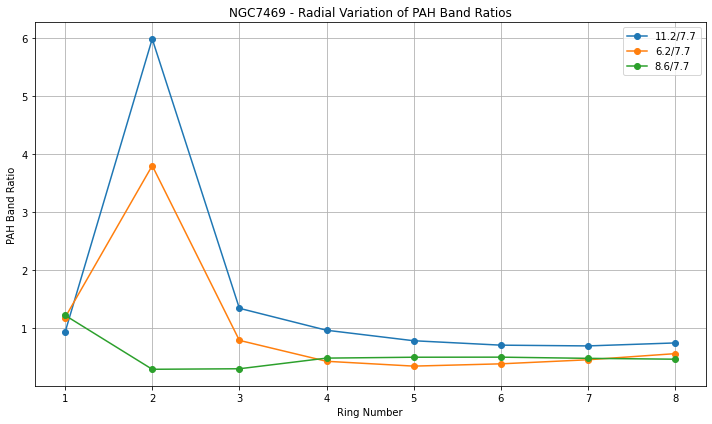

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pathlib import Path

# Key PAH band centers (μm) and labels
pah_centers = [6.2, 7.7, 8.6, 11.2, 12.7]
pah_labels = ['6.2', '7.7', '8.6', '11.2', '12.7']

def band_integral(wavelength, flux, center, width=0.2):
    """Integrate flux around a PAH band center."""
    mask = (wavelength > (center - width)) & (wavelength < (center + width))
    return np.trapz(flux[mask], wavelength[mask]) if np.any(mask) else np.nan

def plot_pah_ratios(galaxy_folder: Path, n_rings: int = 8):
    """
    Compute PAH band strengths and ratios for a given galaxy, and plot radial variations.
    
    Parameters
    ----------
    galaxy_folder : Path
        Folder containing PAH-only FITS files named <galaxy_name>_Ring{i}_pahonly.fits
    n_rings : int
        Number of rings to process
    """
    galaxy_folder = Path(galaxy_folder)
    galaxy_name = galaxy_folder.name

    ratios_112_77, ratios_62_77, ratios_86_77 = [], [], []

    for i in range(1, n_rings + 1):
        fits_file = galaxy_folder / f"{galaxy_name}_Ring{i}_pahonly.fits"
        if not fits_file.exists():
            print(f"[SKIP] Not found: {fits_file.name}")
            ratios_112_77.append(np.nan)
            ratios_62_77.append(np.nan)
            ratios_86_77.append(np.nan)
            continue

        table = Table.read(fits_file, hdu=1)
        wavelength = np.array(table['wavelength'])
        flux = np.array(table['flux'])

        band_fluxes = [band_integral(wavelength, flux, c) for c in pah_centers]

        r112_77 = band_fluxes[3] / band_fluxes[1] if band_fluxes[1] else np.nan
        r62_77  = band_fluxes[0] / band_fluxes[1] if band_fluxes[1] else np.nan
        r86_77  = band_fluxes[2] / band_fluxes[1] if band_fluxes[1] else np.nan

        ratios_112_77.append(r112_77)
        ratios_62_77.append(r62_77)
        ratios_86_77.append(r86_77)

        # Print diagnostic
        print(f"\n=== Ring {i} ===")
        for label, val in zip(pah_labels, band_fluxes):
            print(f"PAH {label} μm band strength: {val:.3g}")
        print(f"11.2/7.7: {r112_77:.2f}   6.2/7.7: {r62_77:.2f}   8.6/7.7: {r86_77:.2f}")

    # Plot ratios vs ring number
    rings = np.arange(1, n_rings + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(rings, ratios_112_77, 'o-', label='11.2/7.7')
    plt.plot(rings, ratios_62_77,  'o-', label='6.2/7.7')
    plt.plot(rings, ratios_86_77,  'o-', label='8.6/7.7')
    plt.xlabel("Ring Number")
    plt.ylabel("PAH Band Ratio")
    plt.title(f"{galaxy_name} - Radial Variation of PAH Band Ratios")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
galaxy_folder = Path(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469")
plot_pah_ratios(galaxy_folder)

<div style="font-size:40px; color:#0F2080;">
  PAH<span style="color:#F5793A;">db
</div>

C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


The relative error between two consecutive iterates is at most 0.000000
[PAHFIT] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring1_pahfit.ecsv
[PAH-only FITS] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring1_pahonly.fits
[pyPAHdb] Saved IPAC table: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring1_pahs.tbl


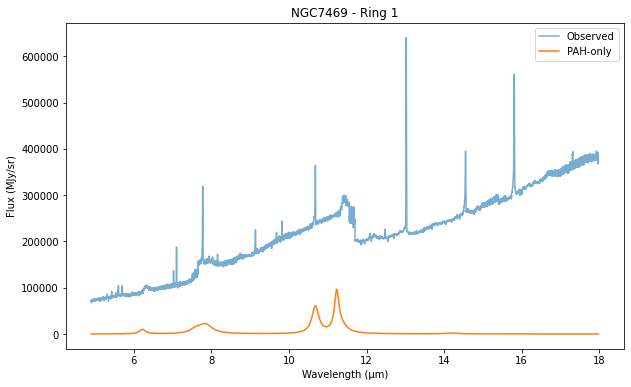

C:\Users\Juan\anaconda3\lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [72]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model
import astropy.units as u

def run_pahfit_for_galaxy(galaxy_folder: Path, n_rings: int = 8, redshift: float = 0.016268):
    """
    Runs PAHFIT, extracts PAH-only spectra, and writes pyPAHdb-compatible .tbl files (minimal lam/flux).
    """
    galaxy_folder = Path(galaxy_folder)
    galaxy_name = galaxy_folder.name
    results_dir = galaxy_folder / "PAHFIT_results"
    results_dir.mkdir(exist_ok=True)

    for i in range(1, n_rings + 1):
        fits_file = galaxy_folder / f"{galaxy_name}_Ring{i}_1dspec.fits"
        if not fits_file.exists():
            print(f"[SKIP] Not found: {fits_file}")
            continue

        # --- Load spectrum ---
        table = Table.read(fits_file, hdu=1)
        wavelengths = u.Quantity(table['wavelength'].data, unit=u.um)
        fluxes = u.Quantity(table['flux'].data, unit=u.MJy / u.sr)
        errors = StdDevUncertainty(0.05 * fluxes)

        spec = Spectrum1D(spectral_axis=wavelengths, flux=fluxes, uncertainty=errors)
        spec.meta['instrument'] = 'jwst.miri.*.*'
        spec.set_redshift_to(redshift)

        # --- Fit with PAHFIT ---
        model = Model.from_yaml('classic.yaml')
        model.features.meta["user_unit"]["flux"] = fluxes.unit
        model.guess(spec)
        model.fit(spec)

        # Save standard PAHFIT ECSV
        output_ecsv = results_dir / f"{galaxy_name}_Ring{i}_pahfit.ecsv"
        model.save(str(output_ecsv), overwrite=True)
        print(f"[PAHFIT] Saved: {output_ecsv}")

        # --- Extract PAH-only flux ---
        lam = np.array(spec.spectral_axis)  # μm
        pahs = np.zeros_like(lam)
        for comp in model.astropy_result:
            if hasattr(comp, "name") and "PAH" in comp.name:
                pahs += comp(lam)

        # Save PAH-only FITS (legacy)
        pah_table = Table()
        pah_table['wavelength'] = lam
        pah_table['flux'] = pahs
        pah_file = results_dir / f"{galaxy_name}_Ring{i}_pahonly.fits"
        pah_table.write(pah_file, overwrite=True)
        print(f"[PAH-only FITS] Saved: {pah_file}")

        from astropy.io import ascii

        # Save pyPAHdb-compatible IPAC .tbl
        ipac_table = Table()
        ipac_table["Wavelength"] = lam.astype(float)      # wavelength in μm
        ipac_table["Flux"] = pahs.astype(float) * 1e-20  # convert to Jy (example scaling)

        # Add column units explicitly
        ipac_table["Wavelength"].unit = "micron"
        ipac_table["Flux"].unit = "Jy"

        tbl_file = results_dir / f"{galaxy_name}_Ring{i}_pahs.tbl"
        ascii.write(ipac_table, tbl_file, format="ipac", overwrite=True)
        print(f"[pyPAHdb] Saved IPAC table: {tbl_file}")


        # --- Quick check plot ---
        plt.figure(figsize=(10, 6))
        plt.plot(lam, fluxes.value, label="Observed", alpha=0.6)
        plt.plot(lam, pahs, label="PAH-only")
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Flux (MJy/sr)")
        plt.title(f"{galaxy_name} - Ring {i}")
        plt.legend()
        plt.show()

run_pahfit_for_galaxy(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469", n_rings=1)

from pypahdb.observation import Observation
from pypahdb.decomposer import Decomposer

tbl_file = r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring1_pahs.tbl"

obs = Observation(tbl_file)
fit = Decomposer(obs.spectrum)
fit.save_pdf("Ring1_pypahdb_fit.pdf", domaps=False)
fit.save_fits("Ring1_pypahdb_fit.fits", header=obs.header)


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


The relative error between two consecutive iterates is at most 0.000000
[PAHFIT] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring1_pahfit.ecsv
[PAH-only FITS] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring1_pahonly.fits
[pyPAHdb] Saved IPAC table: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring1_pahs.tbl


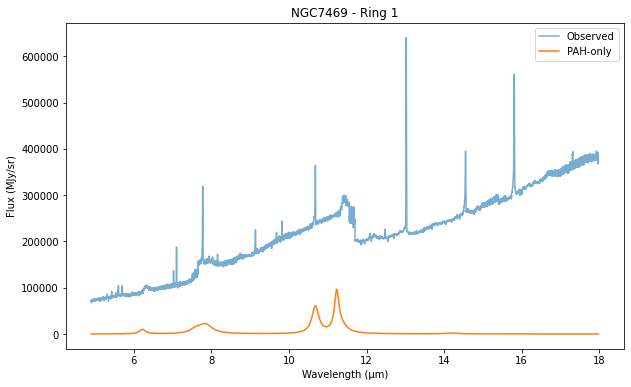

C:\Users\Juan\anaconda3\lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[pyPAHdb] Decomposition completed for Ring 1


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring2_pahfit.ecsv
[PAH-only FITS] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring2_pahonly.fits
[pyPAHdb] Saved IPAC table: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring2_pahs.tbl


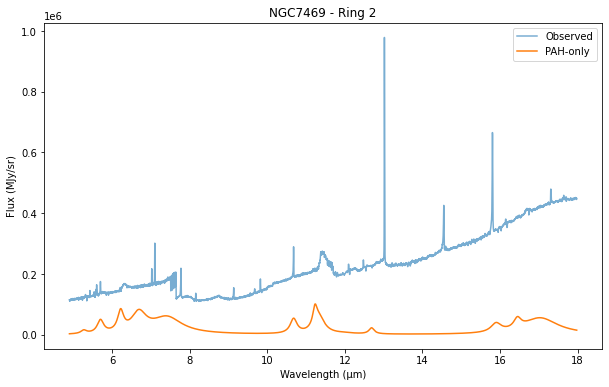

C:\Users\Juan\anaconda3\lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[pyPAHdb] Decomposition completed for Ring 2


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring3_pahfit.ecsv
[PAH-only FITS] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring3_pahonly.fits
[pyPAHdb] Saved IPAC table: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring3_pahs.tbl


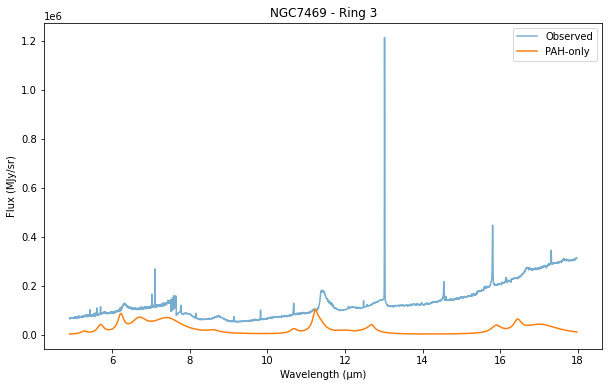

C:\Users\Juan\anaconda3\lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[pyPAHdb] Decomposition completed for Ring 3


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
[PAHFIT] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring4_pahfit.ecsv
[PAH-only FITS] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring4_pahonly.fits
[pyPAHdb] Saved IPAC table: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring4_pahs.tbl


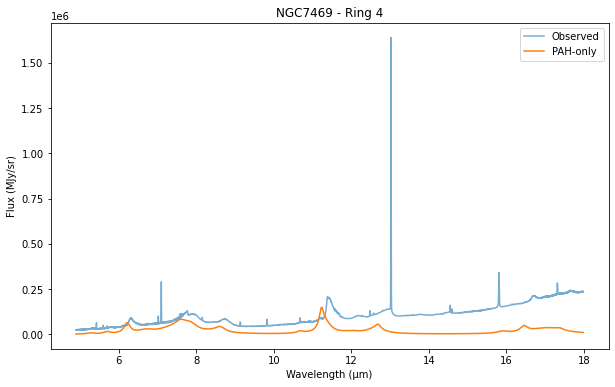

C:\Users\Juan\anaconda3\lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[pyPAHdb] Decomposition completed for Ring 4


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


The relative error between two consecutive iterates is at most 0.000000
[PAHFIT] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring5_pahfit.ecsv
[PAH-only FITS] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring5_pahonly.fits
[pyPAHdb] Saved IPAC table: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring5_pahs.tbl


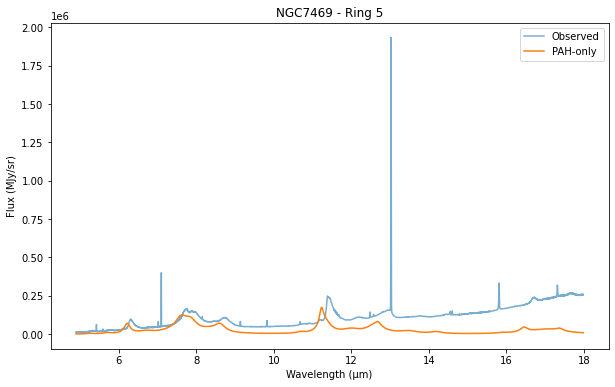

C:\Users\Juan\anaconda3\lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[pyPAHdb] Decomposition completed for Ring 5


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring6_pahfit.ecsv
[PAH-only FITS] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring6_pahonly.fits
[pyPAHdb] Saved IPAC table: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring6_pahs.tbl


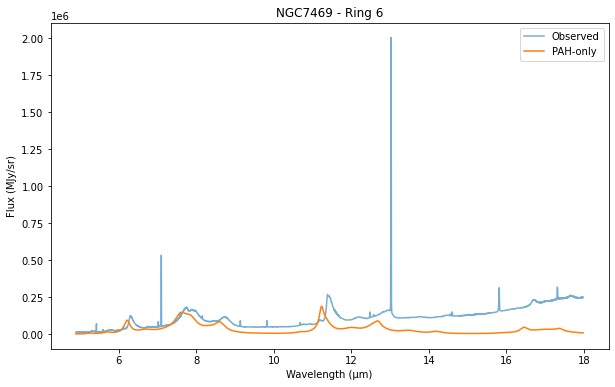

C:\Users\Juan\anaconda3\lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[pyPAHdb] Decomposition completed for Ring 6


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring7_pahfit.ecsv
[PAH-only FITS] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring7_pahonly.fits
[pyPAHdb] Saved IPAC table: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring7_pahs.tbl


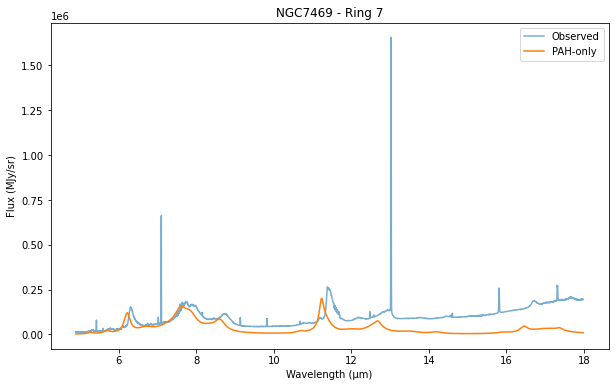

C:\Users\Juan\anaconda3\lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[pyPAHdb] Decomposition completed for Ring 7


C:\Users\Juan\anaconda3\lib\site-packages\numpy\ma\core.py:1163: RuntimeWarning: overflow encountered in divide
  result = self.f(da, db, *args, **kwargs)


Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
[PAHFIT] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring8_pahfit.ecsv
[PAH-only FITS] Saved: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring8_pahonly.fits
[pyPAHdb] Saved IPAC table: C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469\PAHFIT_results\NGC7469_Ring8_pahs.tbl


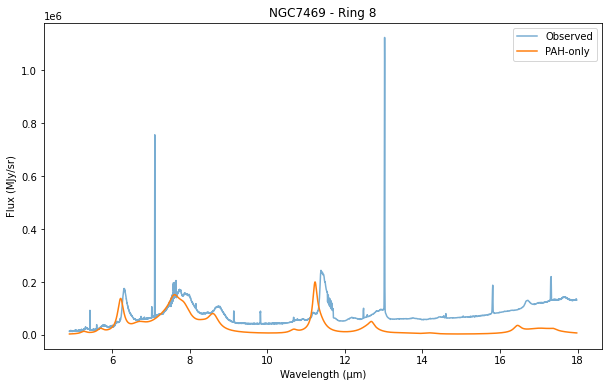

C:\Users\Juan\anaconda3\lib\site-packages\astropy\units\quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


[pyPAHdb] Decomposition completed for Ring 8


In [73]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.nddata import StdDevUncertainty
from specutils import Spectrum1D
from pahfit.modelj import Model
import astropy.units as u
from astropy.io import ascii
from pypahdb.observation import Observation
from pypahdb.decomposer import Decomposer

def run_pahfit_and_pahdb(galaxy_folder: Path, n_rings: int = 8, redshift: float = 0.016268):
    """
    Runs PAHFIT, extracts PAH-only spectra, writes pyPAHdb-compatible .tbl files,
    and runs pyPAHdb decomposition for all rings.
    """
    galaxy_folder = Path(galaxy_folder)
    galaxy_name = galaxy_folder.name
    results_dir = galaxy_folder / "PAHFIT_results"
    results_dir.mkdir(exist_ok=True)

    for i in range(1, n_rings + 1):
        fits_file = galaxy_folder / f"{galaxy_name}_Ring{i}_1dspec.fits"
        if not fits_file.exists():
            print(f"[SKIP] Not found: {fits_file}")
            continue

        # --- Load spectrum ---
        table = Table.read(fits_file, hdu=1)
        wavelengths = u.Quantity(table['wavelength'].data, unit=u.um)
        fluxes = u.Quantity(table['flux'].data, unit=u.MJy / u.sr)
        errors = StdDevUncertainty(0.05 * fluxes)

        spec = Spectrum1D(spectral_axis=wavelengths, flux=fluxes, uncertainty=errors)
        spec.meta['instrument'] = 'jwst.miri.*.*'
        spec.set_redshift_to(redshift)

        # --- Fit with PAHFIT ---
        model = Model.from_yaml('classic.yaml')
        model.features.meta["user_unit"]["flux"] = fluxes.unit
        model.guess(spec)
        model.fit(spec)

        # Save standard PAHFIT ECSV
        output_ecsv = results_dir / f"{galaxy_name}_Ring{i}_pahfit.ecsv"
        model.save(str(output_ecsv), overwrite=True)
        print(f"[PAHFIT] Saved: {output_ecsv}")

        # --- Extract PAH-only flux ---
        lam = np.array(spec.spectral_axis)  # μm
        pahs = np.zeros_like(lam)
        for comp in model.astropy_result:
            if hasattr(comp, "name") and "PAH" in comp.name:
                pahs += comp(lam)

        # Save PAH-only FITS (legacy)
        pah_table = Table()
        pah_table['wavelength'] = lam
        pah_table['flux'] = pahs
        pah_file = results_dir / f"{galaxy_name}_Ring{i}_pahonly.fits"
        pah_table.write(pah_file, overwrite=True)
        print(f"[PAH-only FITS] Saved: {pah_file}")

        # Save pyPAHdb-compatible IPAC .tbl
        ipac_table = Table()
        ipac_table["Wavelength"] = lam.astype(float)
        ipac_table["Flux"] = pahs.astype(float) * 1e-20  # adjust scaling if needed
        ipac_table["Wavelength"].unit = "micron"
        ipac_table["Flux"].unit = "Jy"

        tbl_file = results_dir / f"{galaxy_name}_Ring{i}_pahs.tbl"
        ascii.write(ipac_table, tbl_file, format="ipac", overwrite=True)
        print(f"[pyPAHdb] Saved IPAC table: {tbl_file}")

        # --- Quick check plot ---
        plt.figure(figsize=(10, 6))
        plt.plot(lam, fluxes.value, label="Observed", alpha=0.6)
        plt.plot(lam, pahs, label="PAH-only")
        plt.xlabel("Wavelength (μm)")
        plt.ylabel("Flux (MJy/sr)")
        plt.title(f"{galaxy_name} - Ring {i}")
        plt.legend()
        plt.show()

        # --- Run pyPAHdb decomposition ---
        try:
            obs = Observation(tbl_file)
            fit = Decomposer(obs.spectrum)
            fit.save_pdf(results_dir / f"{galaxy_name}_Ring{i}_pypahdb_fit.pdf", domaps=False)
            fit.save_fits(results_dir / f"{galaxy_name}_Ring{i}_pypahdb_fit.fits", header=obs.header)
            print(f"[pyPAHdb] Decomposition completed for Ring {i}")
        except Exception as e:
            print(f"[pyPAHdb] Could not decompose Ring {i}: {e}")

# Example usage
run_pahfit_and_pahdb(r"C:\Users\Juan\Downloads\Research\JWSTPAH\3_Hydrocarbons\NGC7469", n_rings=8)
